In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib


In [2]:
matplotlib.rcParams['agg.path.chunksize'] = 100000   #it was giving error while plotting large number of points this line solved it.

In [3]:
train_df = pd.read_csv("../input/train.csv",nrows = 300000)

In [ ]:
train_df.head()

In [4]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])

In [5]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,300000.000000,300000.000000,300000.000000,299998.000000,299998.000000,300000.000000
mean,11.359876,-72.523230,39.928171,-72.529448,39.927360,1.684403
std,9.932815,11.325144,8.953498,10.914682,6.546706,1.309132
min,-44.900000,-740.000000,-3116.285383,-1329.621332,-1189.615440,0.000000
25%,6.000000,-73.992050,40.734985,-73.991350,40.734059,1.000000
50%,8.500000,-73.981762,40.752737,-73.980116,40.753185,1.000000
75%,12.500000,-73.967097,40.767108,-73.963565,40.768095,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


One of the major anomaly in training data  from this statistical analysis is there are many outliers that may lead us to wrong predictions.

Mean of fare amount is 11.35 where as the minimum is -44 and maximum is 200. We can definitely conclude that there are many definite outliers here.

Same is true for almost all the columns of our datframe hence it would be wise to remove such outliers before modelling. 
These outliers might have arived due to many reasons such as faulty gps or errors in aggrigation methods but to make our model more accurate we have to remove them. But first let us visualize out data so that the situation of such outliers will be more clear.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of fare')

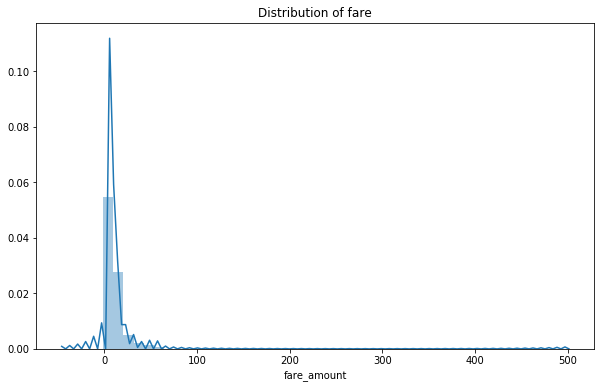

In [6]:
plt.figure(figsize = (10,6))
sns.distplot(train_df['fare_amount']);
plt.title('Distribution of fare')

As we can see most of the fare prices lies between 0-50 rest are all outliers.

In [7]:
#removing values below 0. Certainly an wrong entry.. may be cabbi has broken some rule and hence fined.
#whatever it is we need to remove them.
#train_df[(train_df['fare_amount']<0)].shape[0]#13 such entries

In [8]:

train_df = train_df[(train_df['fare_amount']>0)]
train_df = train_df[(train_df['fare_amount']<=100)]
#train_df['fare_amount'].size 

Text(0.5,1,'Distribution of latitude')

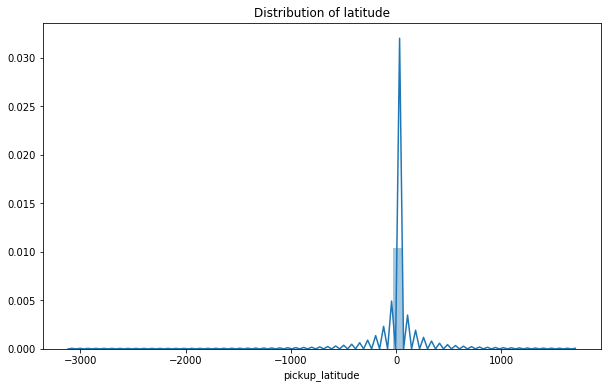

In [9]:
plt.figure(figsize = (10,6))
sns.distplot(train_df['pickup_latitude']);
plt.title('Distribution of latitude')


In [ ]:
#40.7128° N  <-- New York City latitude
#train_df['pickup_latitude'].mean() #mean of the data we have. (kinda accurate) Fact: 1 degree latitude is 69 miles so all the values other than 38-42 are outliers

Text(0.5,1,'Distribution of latitude in more detail')

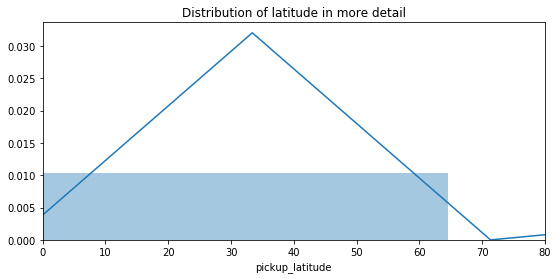

In [10]:
plt.figure(figsize = (9,4))
sns.distplot(train_df['pickup_latitude'])
plt.xlim(0,80)
plt.title('Distribution of latitude in more detail')
#There is lot of values between 10-20. I dont know why

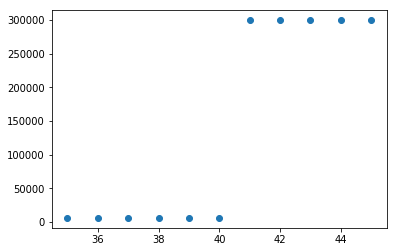

In [11]:
cnt = []
r = [35,36,37,38,39,40,41,42,43,44,45]
for i in r:
    no = train_df[(train_df['pickup_latitude']<i)].shape[0]
    cnt.append(no)
plt.scatter(r,cnt) #see the jump

In [12]:
train_df = train_df[(train_df['pickup_latitude']>0)]
train_df = train_df[(train_df['pickup_latitude']>39)] #-->111 #there are only 20 <39 and 111 greater than 4 so removing them
train_df = train_df[(train_df['pickup_latitude']<42)]
#we can see mean has increased
train_df['pickup_latitude'].shape[0]

294067

Text(0.5,1,'Distribution of longitude')

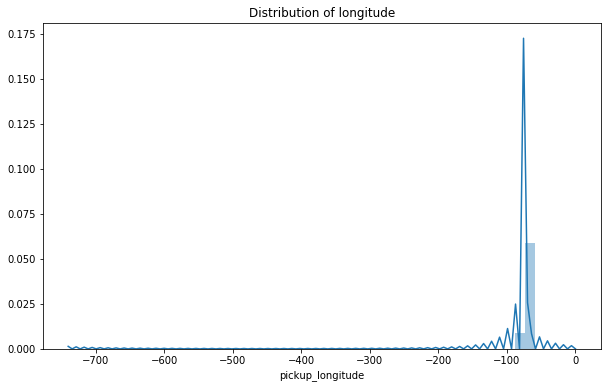

In [13]:
#longitude
#NYC longitude -> 74.0060° W
train_df['pickup_longitude'].mean() #-->-73.96832831445111
plt.figure(figsize = (10,6))
sns.distplot(train_df['pickup_longitude']);
plt.title('Distribution of longitude') #There are outliers nee to remove them

In [14]:
train_df = train_df[(train_df['pickup_longitude']>-75)]
train_df = train_df[(train_df['pickup_longitude']<-72)]

In [15]:
train_df['dropoff_longitude'].mean() #-->-73.90602772217527
train_df['dropoff_latitude'].mean() #--> 40.72183614573583
train_df.shape[0]

294007

In [16]:
train_df = train_df[(train_df['dropoff_longitude']>-75)]
train_df = train_df[(train_df['dropoff_longitude']<-72)]
train_df['dropoff_longitude'].mean() #->-73.90602772217527

-73.97416738711348

In [17]:
train_df = train_df[(train_df['dropoff_latitude']>39)] #-->111 #there are only 20 <39 and 111 greater than 4 so removing them
train_df = train_df[(train_df['dropoff_latitude']<42)]
train_df['dropoff_latitude'].mean()  #->40.72183614573583

40.751280410447826

Now last feature no of passengers

In [18]:
train_df['passenger_count'].describe()

count    293714.000000
mean          1.684925
std           1.309316
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

Text(0.5,1,'passenger_count')

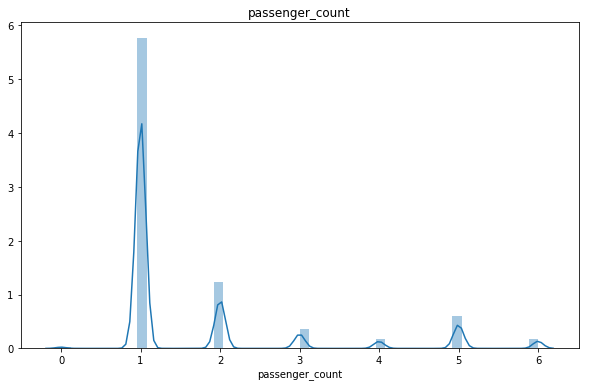

In [19]:

plt.figure(figsize = (10,6))
sns.distplot(train_df['passenger_count']);
plt.title('passenger_count') #At this moment I dont think there is any need to preprocess this data

There are zero passengers

In [20]:
train_df = train_df[(train_df['passenger_count']>0)]

**So preprocessing is done lets take overview**

In [21]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,292659.000000,292659.000000,292659.000000,292659.000000,292659.000000,292659.000000
mean,11.297938,-73.975172,40.750945,-73.974162,40.751276,1.690999
std,9.368012,0.039147,0.032324,0.038370,0.034984,1.307752
min,0.010000,-74.968142,39.449402,-74.960020,39.296307,1.000000
25%,6.000000,-73.992268,40.736600,-73.991530,40.735599,1.000000
50%,8.500000,-73.982057,40.753460,-73.980560,40.753910,1.000000
75%,12.500000,-73.968333,40.767512,-73.965241,40.768380,2.000000
max,100.000000,-72.702870,41.800252,-72.694838,41.923820,6.000000


**Data is preprocessed. I think generally fare amount will depend on the distance travelled by the vehicle. So we need to calculate the distance travelled by the vehicle. Another important point is New York has streets in grid so we may need to find that distance travelled is quite different than eucledian distance.
Now Important point is lattitude and longitude are not cartessian co ordinates so can't use simple distance formula insted have to use haversine formula[1]. Which is: {\displaystyle \operatorname {hav} \left(\Theta \right)=\operatorname {hav} (\varphi _{2}-\varphi _{1})+\cos(\varphi _{1})\cos(\varphi _{2})\operatorname {hav} (\lambda _{2}-\lambda _{1})} <--- This is Scary so I am going to use ready made github code with changing math library to numpy[2]
[1] https://math.stackexchange.com/questions/29157/how-do-i-convert-the-distance-between-two-lat-long-points-into-feet-meters
[2] https://gist.github.com/rochacbruno/2883505


****

In [22]:
def distance(pickup1,pickup2,destination1,destination2):   #spherical distance  
    lat1, lon1 = pickup1,pickup2
    lat2, lon2 = destination1,destination2
    radius = 3959 # miles

    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c

    return d

In [23]:
def distance1(pickup1,pickup2,destination1,destination2):  #Eucledian
    a = (destination1 - pickup1)*69
    b = (destination2 - pickup2)*69
    d = a**2+b**2
    c = np.sqrt(d)
    return c

In [24]:
a = train_df['pickup_latitude'].values
b = train_df['pickup_longitude'].values
c = train_df['dropoff_latitude'].values
d = train_df['dropoff_longitude'].values

In [25]:
dist = distance(a,b,c,d)
dist = pd.Series(dist,index = train_df.index)
train_df['distance_sp'] = dist

In [26]:
dist1 = distance1(a,b,c,d)
dist1 = pd.Series(dist1,index = train_df.index)
train_df['distance_eucle'] = dist1


In [27]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_sp,distance_eucle
count,292659.000000,292659.000000,292659.000000,292659.000000,292659.000000,292659.000000,292659.000000,292659.000000
mean,11.297938,-73.975172,40.750945,-73.974162,40.751276,1.690999,2.077741,2.363530
std,9.368012,0.039147,0.032324,0.038370,0.034984,1.307752,2.470401,2.897548
min,0.010000,-74.968142,39.449402,-74.960020,39.296307,1.000000,0.000000,0.000000
25%,6.000000,-73.992268,40.736600,-73.991530,40.735599,1.000000,0.780653,0.884961
50%,8.500000,-73.982057,40.753460,-73.980560,40.753910,1.000000,1.340557,1.507894
75%,12.500000,-73.968333,40.767512,-73.965241,40.768380,2.000000,2.437772,2.677874
max,100.000000,-72.702870,41.800252,-72.694838,41.923820,6.000000,108.627420,115.681074


In [28]:
p_coef = sc.stats.pearsonr(train_df["distance_eucle"].values,train_df["passenger_count"].values)
p_coef

(0.008882867387138919, 1.5434601640836244e-06)

In [29]:
p_coef1 = sc.stats.pearsonr(train_df["pickup_datetime"].dt.hour.values,train_df["distance_eucle"].values)
p_coef1

(-0.029413070072964537, 4.966985115327951e-57)

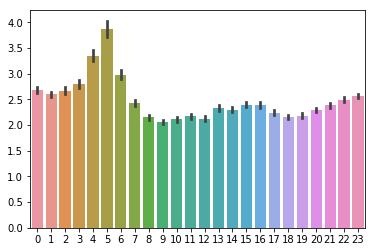

In [30]:
sns.barplot(x=train_df["pickup_datetime"].dt.hour.values,y=train_df["distance_eucle"].values)

In [31]:
p_coef1 = sc.stats.pearsonr(train_df["pickup_datetime"].dt.hour.values,train_df["fare_amount"].values)
p_coef1

(-0.01998155689726739, 3.064938752279907e-27)

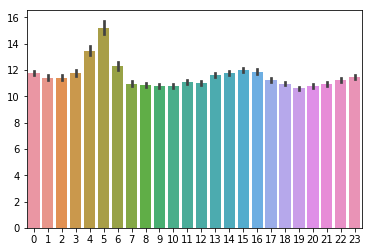

In [32]:
sns.barplot(x=train_df["pickup_datetime"].dt.hour.values,y=train_df["fare_amount"].values)